### First cell can be skipped if you are not working with: https://colab.research.google.com/

In [1]:
!pip3 install http://download.pytorch.org/whl/cu90/torch-0.3.1-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [0]:
import torch
import math
import os

from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import seaborn as sns
from sklearn.model_selection import KFold
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def create_mnist_model():
  return nn.Sequential(
      nn.Linear(784, 100),
      nn.ReLU(),
      nn.Linear(100, 10)
  )

In [0]:
def get_datasets(mini_batch_size=100):
  transform = transforms.ToTensor()
  root = './data'
  if not os.path.exists(root):
    os.mkdir(root)
  # Load and transform data
  train_dataset = torchvision.datasets.MNIST(root, train=True, download=True, transform=transform)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=2)

  test_dataset = torchvision.datasets.MNIST(root, train=False, download=True, transform=transform)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=2)
  return  train_dataset, train_loader, test_dataset, test_loader

Function for training and validation/testing

In [0]:
def train_model(train_loader, model, criterion, optimizer):
    # Set model for training
    model.train()
    
    # Initialize counters to 0
    nb_correct = 0
    nb_elem = 0
    loss_epoch = 0
    
    # Iterate over batches
#     print("before first loop")
    for i, data in enumerate(train_loader):
        # Create Variable
#         print("variable")
        train_data, train_labels = data
        train_data = train_data.view(train_data.size(0),-1).float()
        
        mean, std = train_data.mean(), train_data.std()
        train_data.sub_(mean).div_(std)

        inputs = Variable(train_data)
        targets = Variable(train_labels)
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          targets = targets.cuda()

        # Clear gradients
        model.zero_grad()

        # Forward pass
#         print("type(inputs)",type(inputs))
#         print("inputs.size()",inputs.size())
        
        outputs = model(inputs)

        # Predicted labels (the one with highest probability)
        pred_label = outputs.data.max(1)[1]

         # Compute and store the loss
        loss = criterion(outputs, targets)
        loss_epoch += loss.data[0]
        
        # Update nb. correct and nb of elem
        nb_correct += (pred_label == targets.data).sum()
        nb_elem += len(pred_label)

        # Backward pass
        loss.backward()
        optimizer.step()
    
    loss_epoch /=nb_elem
    acc_epoch = nb_correct/nb_elem
#     print("loss_epoch")
    return loss_epoch, acc_epoch, mean, std


def validate_model(val_loader, model, criterion, mean, std):
    # Switch to evaluate mode
    model.eval()

    # Initialize counters
    nb_correct = 0
    nb_elem = 0
    loss_epoch = 0
    
    # Iterate over batches
    for data in val_loader:
        # Create Variable
        val_data, val_labels = data
        val_data = val_data.view(val_data.size(0),-1).float()
        val_data.sub_(mean).div_(std)
        inputs = Variable(val_data)
        targets = Variable(val_labels)
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          targets = targets.cuda()
        
        # Obtain predictions
        outputs = model(inputs)
        
        # Predicted label (highest probability)
        pred_label = outputs.data.max(1)[1]

        # Loss
        loss = criterion(outputs, targets)
        loss_epoch += loss.data[0]

        # Update nb. correct and nb. total
        nb_correct += (pred_label == targets.data).sum()
        nb_elem += len(pred_label)
        
    loss_epoch/=nb_elem
    acc_epoch = nb_correct/nb_elem
    return loss_epoch, acc_epoch

Main function for training and validation k-fold

In [0]:
def train_model_kfold_sgd(model, train_dataset, kfold=5, shuffle=True, nb_epochs = 150, mini_batch_size = 100, lr = 1e-1):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr)
  
  from sklearn.model_selection import KFold
  from torch.utils.data.sampler import SubsetRandomSampler

  kf = KFold(n_splits = kfold, shuffle=shuffle)

  # Define vectors to store results for each fold
  train_loss_kfold = []
  val_loss_kfold = []
  train_acc_kfold = []
  val_acc_kfold = []
  
  for train_index, val_index in kf.split(train_dataset.train_data):
    print("New split of data")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=mini_batch_size, sampler=train_sampler, drop_last=False)
#     print(len(train_loader))
    
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=mini_batch_size, sampler=val_sampler, drop_last=False)
#     print(len(val_loader))
    
    model = create_mnist_model()
    if torch.cuda.is_available():
      model = model.cuda()
      #train_dataset.input, val_dataset.input = train_input.cuda(), train_target.cuda(),test_input.cuda(), test_target.cuda()

    # Store loss and accuracy per each epoch
    train_e_loss = []
    val_e_loss = []
    train_e_acc = []
    val_e_acc = []
    
    if torch.cuda.is_available():
      criterion = nn.CrossEntropyLoss().cuda()
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2))
    optimizer = optim.SGD(model.parameters(), lr)
    
    for epoch in range(0, nb_epochs):
      if (epoch%10==0):
        print(epoch)
      # for this epoch calculate train loss, accuracy
      train_loss, train_acc, mean, std = train_model(train_loader, model, criterion, optimizer)
      # Store them in list to be able to plot
      train_e_loss.append(train_loss)
      train_e_acc.append(train_acc)

      # Evaluate for epoch val loss and accuracy
      val_loss, val_acc = validate_model(val_loader, model, criterion, mean, std)
      # Store them in the list to be able to plot
      val_e_loss.append(val_loss)
      val_e_acc.append(val_acc)
    
    # for k-fold sets, store loss and accuracy through epochs 
    train_loss_kfold.append(train_e_loss)
    val_loss_kfold.append(val_e_loss)
    train_acc_kfold.append(train_e_acc)
    val_acc_kfold.append(val_e_acc)
    
  return train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold

In [0]:
def train_model_kfold_adam(model, train_dataset, kfold=5, shuffle=True, nb_epochs = 150, mini_batch_size = 100, lr = 1e-1, beta1=0.9, beta2=0.999):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr)
  
  from sklearn.model_selection import KFold
  from torch.utils.data.sampler import SubsetRandomSampler

  kf = KFold(n_splits = kfold, shuffle=shuffle)

  # Define vectors to store results for each fold
  train_loss_kfold = []
  val_loss_kfold = []
  train_acc_kfold = []
  val_acc_kfold = []
  
  for train_index, val_index in kf.split(train_dataset.train_data):
    print("New split of data")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=mini_batch_size, sampler=train_sampler, drop_last=False)
#     print(len(train_loader))
    
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=mini_batch_size, sampler=val_sampler, drop_last=False)
#     print(len(val_loader))
    
    model = create_mnist_model()
    if torch.cuda.is_available():
      model = model.cuda()
      #train_dataset.input, val_dataset.input = train_input.cuda(), train_target.cuda(),test_input.cuda(), test_target.cuda()

    # Store loss and accuracy per each epoch
    train_e_loss = []
    val_e_loss = []
    train_e_acc = []
    val_e_acc = []
    
    if torch.cuda.is_available():
      criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2))

    for epoch in range(0, nb_epochs):
      if (epoch%10==0):
        print(epoch)
      # for this epoch calculate train loss, accuracy
      train_loss, train_acc, mean, std = train_model(train_loader, model, criterion, optimizer)
      # Store them in list to be able to plot
      train_e_loss.append(train_loss)
      train_e_acc.append(train_acc)

      # Evaluate for epoch val loss and accuracy
      val_loss, val_acc = validate_model(val_loader, model, criterion, mean, std)
      # Store them in the list to be able to plot
      val_e_loss.append(val_loss)
      val_e_acc.append(val_acc)
    
    # for k-fold sets, store loss and accuracy through epochs 
    train_loss_kfold.append(train_e_loss)
    val_loss_kfold.append(val_e_loss)
    train_acc_kfold.append(train_e_acc)
    val_acc_kfold.append(val_e_acc)
    
  return train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold

Function for plotting

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_acc_loss(tr_loss, te_loss, tr_acc, te_acc, title="MNIST"):   
    plt.figure()
    title="MNIST loss"
    sns.tsplot(np.array(tr_loss)).set_title(title)
    sns.tsplot(np.array(te_loss), color = 'r')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.figure()
    title="MNIST accuracy"
    sns.tsplot(np.array(tr_acc)).set_title(title)
    sns.tsplot(np.array(te_acc), color = 'r')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

Main function for training and testing on whole train and test, once the parameters are picked

In [0]:
def train_test_model_sgd(model, train_dataset, test_dataset, shuffle=True, nb_epochs = 150, mini_batch_size = 100, lr = 1e-1):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr)
  
  from torch.utils.data.sampler import SubsetRandomSampler

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=mini_batch_size, sampler=train_sampler, drop_last=False)
#     print(len(train_loader))

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=mini_batch_size, sampler=val_sampler, drop_last=False)
#     print(len(val_loader))

  model = create_mnist_model()
  if torch.cuda.is_available():
    model = model.cuda()
 
  # Store loss and accuracy per each epoch
  train_e_loss = []
  test_e_loss = []
  train_e_acc = []
  test_e_acc = []

  if torch.cuda.is_available():
    criterion = nn.CrossEntropyLoss().cuda()
  #optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2))
  optimizer = optim.SGD(model.parameters(), lr)

  for epoch in range(0, nb_epochs):
    if (epoch%10==0):
      print(epoch)
    # here we normalize data on train set and take mean and std for test set
    train_loss, train_acc, mean, std = train_model(train_loader, model, criterion, optimizer)
    # Store them in list to be able to plot
    train_e_loss.append(train_loss)
    train_e_acc.append(train_acc)

    # Evaluate for epoch val loss and accuracy
    test_loss, test_acc = validate_model(test_loader, model, criterion, mean, std)
    # Store them in the list to be able to plot
    test_e_loss.append(test_loss)
    test_e_acc.append(test_acc)
    
    # for k-fold sets, store loss and accuracy through epochs 
    train_loss_kfold.append(train_e_loss)
    test_loss_kfold.append(test_e_loss)
    train_acc_kfold.append(train_e_acc)
    test_acc_kfold.append(test_e_acc)
    
  return train_loss_kfold, test_loss_kfold, train_acc_kfold, test_acc_kfold

In [0]:
def train_test_model_adam(model, train_dataset, test_dataset, shuffle=True, nb_epochs = 150, mini_batch_size = 100, lr = 1e-1, beta1= 0.9, beta2 = 0.999):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr)
  
  from torch.utils.data.sampler import SubsetRandomSampler

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=mini_batch_size, sampler=train_sampler, drop_last=False)
#     print(len(train_loader))

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=mini_batch_size, sampler=val_sampler, drop_last=False)
#     print(len(val_loader))

  model = create_mnist_model()
  if torch.cuda.is_available():
    model = model.cuda()
 
  # Store loss and accuracy per each epoch
  train_e_loss = []
  test_e_loss = []
  train_e_acc = []
  test_e_acc = []

  if torch.cuda.is_available():
    criterion = nn.CrossEntropyLoss().cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2))

  for epoch in range(0, nb_epochs):
    if (epoch%10==0):
      print(epoch)
    # here we normalize data on train set and take mean and std for test set
    train_loss, train_acc, mean, std = train_model(train_loader, model, criterion, optimizer)
    # Store them in list to be able to plot
    train_e_loss.append(train_loss)
    train_e_acc.append(train_acc)

    # Evaluate for epoch val loss and accuracy
    test_loss, test_acc = validate_model(test_loader, model, criterion, mean, std)
    # Store them in the list to be able to plot
    test_e_loss.append(test_loss)
    test_e_acc.append(test_acc)
    
    # for k-fold sets, store loss and accuracy through epochs 
    train_loss_kfold.append(train_e_loss)
    test_loss_kfold.append(test_e_loss)
    train_acc_kfold.append(train_e_acc)
    test_acc_kfold.append(test_e_acc)
    
  return train_loss_kfold, test_loss_kfold, train_acc_kfold, test_acc_kfold

Load data

In [0]:
mini_batch = 100
train_dataset, train_loader, test_dataset, test_loader = get_datasets(mini_batch_size = mini_batch)

Train the sgd

In [16]:
model = create_mnist_model()
nb_epochs = 100
lr = 1e-1
mini_batch = 100

train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold = train_model_kfold_sgd(model, train_dataset, kfold=2, shuffle=True, nb_epochs = nb_epochs, mini_batch_size = mini_batch, lr = 1e-1)
plot_acc_loss(train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold)

New split of data
0
10
20
30
40
50
60
70
80
90
New split of data
0
10
20
30
40
50
60
70
80
90


NameError: ignored

I have not imported plt, so that was the error

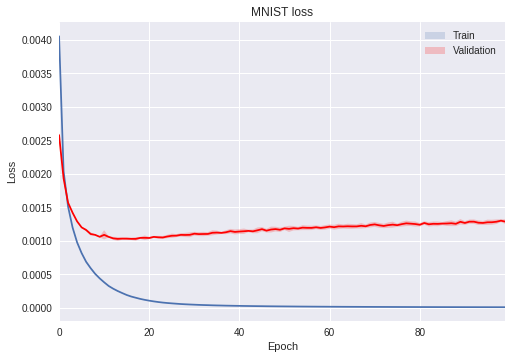

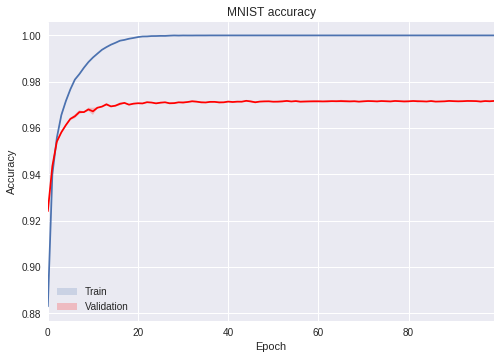

In [21]:
plot_acc_loss(train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold)

In [0]:
# Not fixed params
lr_list = [0.00001, 0.0001, 0.001, 0.01, 0.1]

# Number of epochs we want to run
nb_epochs = 100
mini_batch = 100
kfold = 3

train_dataset, train_loader, test_dataset, test_loader = get_datasets(mini_batch_size = mini_batch)
results = {'lr': [], 'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for lr in lr_list:
  results['lr'] = lr
  print("lr ",lr)
  title = "lr "+str(lr)

  train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold = train_model_kfold_sgd(model, train_dataset, kfold=kfold, shuffle=True, nb_epochs = nb_epochs, mini_batch_size = mini_batch, lr = lr)
  # Plot

  plot_acc_loss(train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold , title)
  train_loss_kfold = np.mean(train_loss_kfold, axis = 0)
  val_loss_kfold = np.mean(val_loss_kfold, axis = 0)
  train_acc_kfold = np.mean(train_acc_kfold, axis = 0)
  val_acc_kfold = np.mean(val_acc_kfold, axis = 0)
  train_acc_kfold = np.mean(train_acc_kfold, axis = 0)
  print("Train accuracy =  ",train_acc_kfold)

  te_acc = np.mean(te_acc, axis = 0)
  print("Val accuracy =  ",val_acc_kfold)

  results['train_loss'].append(train_loss_kfold)
  results['train_acc'].append(train_acc_kfold)
  results['val_loss'].append(val_loss_kfold)
  results['val_acc'].append(val_acc_kfold)

Here we plot matrix with average training and validation accuracy, and decide which number we use

In [0]:
num_of_lr = len(lr_list)
sns.heatmap( np.reshape(np.array(results["train_acc"]),(1,num_of_lr)), annot=True, xticklabels=np.reshape(np.array(nb_hidden_list),(-1,1)), yticklabels=np.reshape(np.array(conv2_list),(-1,1))).set_title('Train accuracy mean')
plt.figure()
sns.heatmap( np.reshape(np.array(results["val_acc"]),(1,num_of_lr)), annot=True, xticklabels=np.reshape(np.array(nb_hidden_list),(-1,1)), yticklabels=np.reshape(np.array(conv2_list),(-1,1))).set_title('Validation accuracy mean')

Train and test on whole datasets with some picked value

In [0]:
train_loss_kfold, test_loss_kfold, train_acc_kfold, test_acc_kfold = train_model_kfold_sgd(model, train_dataset, test_dataset, shuffle=True, nb_epochs = nb_epochs, mini_batch_size = mini_batch, lr = 1e-1)
plot_acc_loss(train_loss_kfold, test_loss_kfold, train_acc_kfold, test_acc_kfold)

Grid search for Adam, i.e. first find best lr, then betas

In [0]:
# Not fixed params
lr_list = [0.00001, 0.0001, 0.001, 0.01, 0.1]

# Number of epochs we want to run
nb_epochs = 100
mini_batch = 100
kfold = 3

train_dataset, train_loader, test_dataset, test_loader = get_datasets(mini_batch_size = mini_batch)
results = {'lr': [], 'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for lr in lr_list:
  results['lr'] = lr
  print("lr ",lr)
  title = "lr "+str(lr)

  train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold = train_model_kfold_adam(model, train_dataset, kfold=kfold, shuffle=True, nb_epochs = nb_epochs, mini_batch_size = mini_batch, lr = lr)
  # Plot

  plot_acc_loss(train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold , title)
  train_loss_kfold = np.mean(train_loss_kfold, axis = 0)
  val_loss_kfold = np.mean(val_loss_kfold, axis = 0)
  train_acc_kfold = np.mean(train_acc_kfold, axis = 0)
  val_acc_kfold = np.mean(val_acc_kfold, axis = 0)
  train_acc_kfold = np.mean(train_acc_kfold, axis = 0)
  print("Train accuracy =  ",train_acc_kfold)

  te_acc = np.mean(te_acc, axis = 0)
  print("Val accuracy =  ",val_acc_kfold)

  results['train_loss'].append(train_loss_kfold)
  results['train_acc'].append(train_acc_kfold)
  results['val_loss'].append(val_loss_kfold)
  results['val_acc'].append(val_acc_kfold)

Here we plot matrix with average training and validation accuracy, and decide which number we use

In [0]:
num_of_lr = len(lr_list)
sns.heatmap( np.reshape(np.array(results["train_acc"]),(1,num_of_lr)), annot=True, xticklabels=np.reshape(np.array(nb_hidden_list),(-1,1)), yticklabels=np.reshape(np.array(conv2_list),(-1,1))).set_title('Train accuracy mean')
plt.figure()
sns.heatmap( np.reshape(np.array(results["val_acc"]),(1,num_of_lr)), annot=True, xticklabels=np.reshape(np.array(nb_hidden_list),(-1,1)), yticklabels=np.reshape(np.array(conv2_list),(-1,1))).set_title('Validation accuracy mean')

Find betas

In [0]:
# Load training dataset
train_dataset, train_loader, test_dataset, test_loader = get_datasets(mini_batch_size = mini_batch)
results = {'beta1': [], 'beta2':[], 'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

# Define minibatch size
nb_epochs = 150
mini_batch = 100
kfold = 3

# this should be best lr
lr = 1e-3
beta1_list = [0.89, 0.91, 0.9]
beta2_list = [0.99, 0.994, 0.998, 0.999]
for beta1 in beta1_list:
  results['beta1'] = beta1
  for beta2 in beta2_list:
    results['beta2'] = beta2
    print("beta1 = ",beta1, " beta2 = ", beta2)
    title = "beta1 = "+str(beta1)+" beta2 = "+str(beta2)

    train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold = train_model_kfold_adam(model, train_dataset, kfold=kfold, shuffle=True, nb_epochs = nb_epochs, mini_batch_size = mini_batch, lr = lr, beta1= beta1, beta2 = beta2)
    # Plot

    plot_acc_loss(train_loss_kfold, val_loss_kfold, train_acc_kfold, val_acc_kfold , title)
    train_loss_kfold = np.mean(train_loss_kfold, axis = 0)
    val_loss_kfold = np.mean(val_loss_kfold, axis = 0)
    train_acc_kfold = np.mean(train_acc_kfold, axis = 0)
    val_acc_kfold = np.mean(val_acc_kfold, axis = 0)
    train_acc_kfold = np.mean(train_acc_kfold, axis = 0)
    print("Train accuracy =  ",train_acc_kfold)

    te_acc = np.mean(te_acc, axis = 0)
    print("Val accuracy =  ",val_acc_kfold)

    results['train_loss'].append(train_loss_kfold)
    results['train_acc'].append(train_acc_kfold)
    results['val_loss'].append(val_loss_kfold)
    results['val_acc'].append(val_acc_kfold)

Pick betas

In [0]:
num_b1 = len(beta1_list)
num_b2 = len(beta2_list)
sns.heatmap( np.reshape(np.array(results["train_acc"]),(num_b1,num_b2)), annot=True, xticklabels=np.reshape(np.array(conv1_list),(-1,1)), yticklabels=np.reshape(np.array(conv2_list),(-1,1))).set_title('Training accuracy mean')
plt.figure()
sns.heatmap( np.reshape(np.array(results["val_acc"]),(num_b1,num_b2)), annot=True, xticklabels=np.reshape(np.array(conv1_list),(-1,1)), yticklabels=np.reshape(np.array(conv2_list),(-1,1))).set_title('Validation accuracy mean')